# Modeling and Evaluation

### Objectives

- Answer business requirement 2:
    - The client is interested to tell whether a given x-ray image contains a fractured bone or not.

### Inputs
- inputs/fracture_dataset/bone_fracture/bone_fracture/train
- inputs/fracture_dataset/bone_fracture/bone_fracture/val
- inputs/fracture_dataset/bone_fracture/bone_fracture/test
- image shape embeddings

### Outputs
- Images distribution plot in train, validation, and test set
- Image augmentation
- Class indices to change prediction inference in labels
- Machine learning model creation and training
- Save model
- Learning curve plot for model performance
- Model evaluation on pickle file
- Prediction on the random image file

---

# Set Data Directory

### Import packages

In [103]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Set Working Directory

In [104]:
current_dir = os.getcwd()
current_dir

'/workspace/Bone-Fracture-Detection'

In [105]:
os.chdir('/workspace/Bone-Fracture-Detection')

In [106]:
work_dir = os.getcwd()
work_dir

'/workspace/Bone-Fracture-Detection'

### Set input directories

In [107]:
parent_path = 'inputs/fracture_dataset/bone_fracture/bone_fracture'
train_path = parent_path + '/train'
val_path = parent_path + '/val'
test_path = parent_path + '/test'

### Set output directories

In [108]:
version = 'v5'
file_path = f'outputs/{version}'


if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
	print('Old version is already available create a new version.')
	pass
else:
	os.makedirs(name = file_path)

Old version is already available create a new version.


### Set labels

In [109]:
labels = os.listdir(train_path)
print('Project Labels: ', labels)

Project Labels:  ['fractured', 'unfractured']


### Set image shape

In [110]:
import joblib


image_shape = joblib.load(filename='outputs/v1/image_shape.pkl')
image_shape

(290, 273, 3)

---

# Check if the datasets are imbalanced

The datasets look balananced, so we can continue.

* train - fractured: 4593 images
* train - unfractured: 4625 images
* val - fractured: 336 images
* val - unfractured: 490 images
* test - fractured: 237 images
* test - unfractured: 267 images


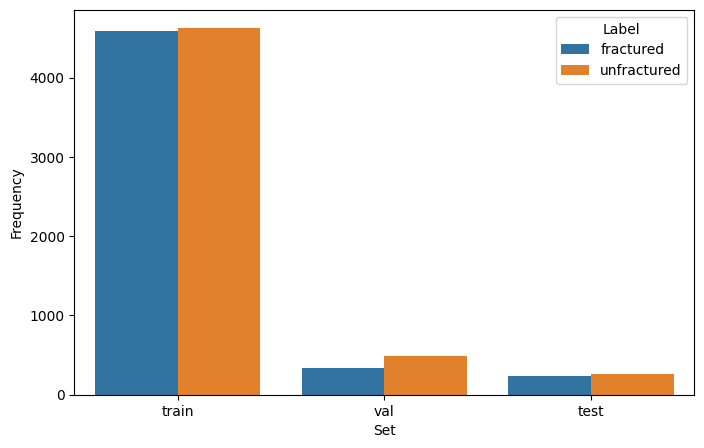

In [111]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'val', 'test']:
	for label in labels:
		df_freq = df_freq.append(
				pd.Series(data={'Set': folder,
								'Label': label,
								'Frequency': int(len(os.listdir(parent_path + '/' + folder + '/' + label)))}
						),
						ignore_index=True
				)
		print(f"* {folder} - {label}: {len(os.listdir(parent_path + '/' + folder + '/' + label))} images")


plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

The dataset contains enough images, so image augmentation isn't needed.

---

# get image class

In [112]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


augmented_image_data = ImageDataGenerator(rescale=1./255)

In [113]:
batch_size = 20
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )


train_set.class_indices

Found 9218 images belonging to 2 classes.


{'fractured': 0, 'unfractured': 1}

In [114]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )


validation_set.class_indices

Found 826 images belonging to 2 classes.


{'fractured': 0, 'unfractured': 1}

In [115]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )


test_set.class_indices

Found 504 images belonging to 2 classes.


{'fractured': 0, 'unfractured': 1}

---

# Model creation

### Import ML packages

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

### ML model

In [117]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=8, kernel_size=(3, 3), input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=8, kernel_size=(3, 3), input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    return model

### Checks model summary

In [118]:
create_tf_model().summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 288, 271, 8)       224       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 144, 135, 8)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 142, 133, 8)       584       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 71, 66, 8)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 69, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 34, 32, 16)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 17408)            

### Early Stopping

In [119]:
from tensorflow.keras.callbacks import EarlyStopping


early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit model for model training

In [120]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
460/460 [==============================] - 278s 602ms/step - loss: 0.6531 - accuracy: 0.6057 - val_loss: 0.5891 - val_accuracy: 0.7046
Epoch 2/25
460/460 [==============================] - 277s 601ms/step - loss: 0.5206 - accuracy: 0.7395 - val_loss: 0.5599 - val_accuracy: 0.7554
Epoch 3/25
460/460 [==============================] - 274s 595ms/step - loss: 0.4158 - accuracy: 0.8146 - val_loss: 0.4498 - val_accuracy: 0.8426
Epoch 4/25
460/460 [==============================] - 277s 602ms/step - loss: 0.3319 - accuracy: 0.8628 - val_loss: 0.3944 - val_accuracy: 0.8596
Epoch 5/25
460/460 [==============================] - 277s 602ms/step - loss: 0.2671 - accuracy: 0.8939 - val_loss: 0.3171 - val_accuracy: 0.8777
Epoch 6/25
460/460 [==============================] - 274s 596ms/step - loss: 0.2177 - accuracy: 0.9163 - val_loss: 0.2579 - val_accuracy: 0.9104
Epoch 7/25
460/460 [==============================] - 277s 601ms/step - loss: 0.1797 - accuracy: 0.9327 - val_loss: 0.2190 -

### Save model

In [121]:
model.save(f'{file_path}/bone_detector_model.h5')

---

# Model Performace

### Model learning curve

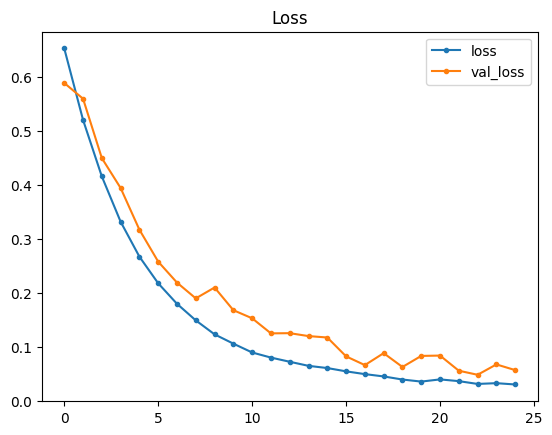

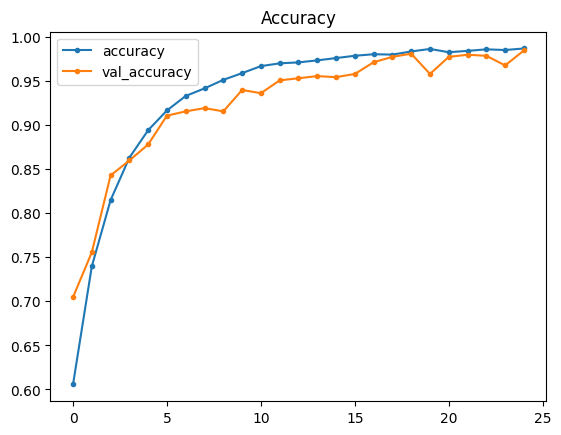

In [123]:
losses = pd.DataFrame(model.history.history)


losses[['loss', 'val_loss']].plot(style='.-')
plt.title('Loss')
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()


losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title('Accuracy')
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

In [131]:
evaluation = model.evaluate(test_set)

26/26 [==============================] - 7s 232ms/step - loss: 0.0393 - accuracy: 0.9921


---

### Model evaluation

Load the saved model and import packages

In [124]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from keras.models import load_model


model = load_model(f'{file_path}/bone_detector_model.h5')

Evaluate model on the test set

In [125]:
evaluation = model.evaluate(test_set)

26/26 [==============================] - 6s 233ms/step - loss: 0.0393 - accuracy: 0.9921


Create a confusion Matrix

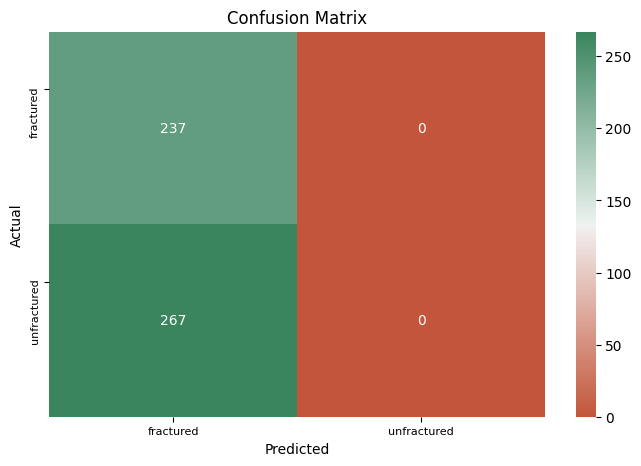

In [126]:
validation_set.reset()


x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels


cm = confusion_matrix(y_true,y_pred)
sns_colours = sns.diverging_palette(20, 145, as_cmap=True)


classes = list(test_set.class_indices.keys()) 
length = len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap=sns_colours)       
plt.xticks(np.arange(length) + .5, classes, rotation=0, fontsize=8)
plt.yticks(np.arange(length) + .3, classes, rotation=90, fontsize=8)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

Save evaluation pickle

In [127]:
joblib.dump(value=evaluation, filename=f'{file_path}/bone_detector_model.h5')

['outputs/v5/bone_detector_model.h5']

---

### Predict on new data

Load a random image from our dataset.

Image shape: (273, 290), Image mode: RGB


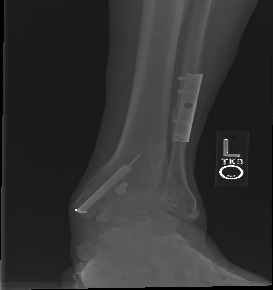

In [128]:
from tensorflow.keras.preprocessing import image


pointer = 20
label = labels[0]


image_file = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path +'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')


print(f'Image shape: {image_file.size}, Image mode: {image_file.mode}')
image_file

Convert image to array and prepare for prediction

In [129]:
my_image = image.img_to_array(image_file)
my_image = np.expand_dims(my_image, axis=0)
print(my_image.shape)

(1, 290, 273, 3)


Predict class probabilities

In [130]:
pred_proba = model.predict(my_image)[0, 0]
target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]  


if pred_class == target_map[0]: pred_proba = 1 - pred_proba


print(pred_proba)
print(pred_class)

1.0
fractured


---

# Conclusions and Next Steps

- Data augmentation techniques were applied to the images.
- The model was developed, trained, and evaluated.
- The similar patterns in the validation and training plots indicate that the model is neither underfitting nor overfitting.
- The model's prediction accuracy has exceeded the required threshold of 97%.
- It can reliably determine whether an image depicts a fractured bone or a healthy bone.